In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import operator

In [29]:
filePath = "data/ml-100k/u1.base"
with open(filePath, "rt") as dataPath:
    raw_data = dataPath.read().splitlines()
datapoints = [[int(i) for i in data.split("\t")] for data in raw_data]

# indexing on users/movies starts at 1, reset to index from 0, this will be important when we do testing
datapoints = np.array([[row[0], row[1], row[2], row[3]] for row in datapoints])
np.random.shuffle(datapoints)

# Used in precision eval... not rly needed given datapoints
user_items = defaultdict(list)
for row in datapoints:
    user_items[row[0]].append(row[1])

user_ids = set([datapoint[0] for datapoint in datapoints])
n_users = len(user_ids)
max_user = max(user_ids) + 1
print("n users:", n_users)
items_ids = set([datapoint[1] for datapoint in datapoints])
n_items = len(items_ids)
max_item = max(items_ids) + 1
print("n items:", n_items)

n users: 943
n items: 1650


In [30]:
import random

# sanity check vs datapoints
user_item_cnts = {}
for user, movies in user_items.items():
    user_item_cnts[user] = len(movies)

top_users = dict(sorted(user_item_cnts.items(), key=operator.itemgetter(1), reverse=True)[:227])
print("User_ids with most watched movies: ", list(top_users.keys())[0:20], ". . .")

cold_start_users = random.sample(list(top_users.keys()), k=200) # Select k users randomly
print("\nNum cold start users: ", len(cold_start_users))

drift_users = random.sample(list(top_users.keys()), k=200)
print("\nDrift user ids: ", drift_users)

User_ids with most watched movies:  [655, 405, 450, 537, 416, 846, 682, 13, 880, 429, 896, 592, 796, 758, 561, 435, 551, 804, 474, 889] . . .

Num cold start users:  200

Drift user ids:  [59, 301, 653, 648, 862, 840, 354, 851, 805, 622, 666, 774, 766, 312, 435, 95, 308, 880, 1, 389, 660, 881, 882, 493, 486, 593, 500, 394, 815, 747, 536, 504, 788, 643, 806, 548, 659, 521, 934, 327, 484, 280, 848, 757, 207, 804, 373, 201, 919, 429, 305, 342, 130, 709, 458, 870, 896, 497, 268, 184, 409, 92, 655, 864, 13, 18, 716, 442, 450, 897, 693, 532, 90, 385, 927, 899, 629, 535, 922, 943, 417, 624, 650, 773, 913, 663, 886, 592, 472, 586, 7, 618, 455, 291, 437, 715, 533, 823, 566, 892, 503, 311, 749, 561, 393, 447, 567, 109, 854, 545, 790, 506, 621, 345, 664, 487, 542, 495, 932, 407, 271, 436, 654, 363, 398, 293, 347, 425, 601, 194, 847, 671, 868, 907, 452, 339, 463, 608, 738, 488, 178, 457, 378, 642, 299, 798, 627, 453, 796, 878, 399, 456, 763, 379, 758, 524, 537, 269, 374, 343, 145, 94, 883, 887, 68

In [5]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


def movie_genres(movie_ids):
    file = "data/ml-100k/u.item" 
    movies = pd.read_csv(file, sep='|', header=None, encoding='UTF-8')
    drop_cols = [2, 3, 4]
    movies = movies.drop(drop_cols, axis=1)
    col_names = ["movie_id", "title", "Unk", "Action", "Adventure", "Animation",
                  "Childrens", "Comedy", "Crime", "Documentary", "Drama",
                  "Fantasy", "Film_Noir", "Horror", "Musical", "Mystery",
                  "Romance", "Sci_Fi", "Thriller", "War", "Western"]
    movies.columns=col_names
    movies.head()
    return movies[movies['movie_id'].isin(movie_ids)].drop('title', axis=1)

def order_movies(userId, movie_split=60):
    file = "data/ml-100k/u1.base"
    with open(filePath, "rt") as dataPath:
        raw_data = dataPath.read().splitlines()
    datapoints = [[int(i) for i in data.split("\t")] for data in raw_data]
    datapoints = np.array([[row[0], row[1], row[3]] for row in datapoints if row[0] == userId])
    sorted(datapoints, key = lambda x: int(x[2]))
    movie_set1, movie_set2 = [], []
    count = 0
    for row in datapoints:
        count += 1
        if count <= movie_split:
            movie_set1.append(row[1])
        elif movie_split < count <= movie_split*2:
            movie_set2.append(row[1])
        else:
            break
    if len(movie_set1) != len(movie_set2):
        print("Error: Movie set lengths differ!")
        return -1, -1
    return movie_set1, movie_set2

def genre_distribution(genre_matrix):
    col_sums = np.sum(genre_matrix.drop('movie_id', axis=1), axis=0)
    distribution = col_sums/sum(col_sums)
    return distribution

def getCosineSimilarity(userId, movie_split):
    # Get list of viewed movies ordered by timestamp
    movie_set1, movie_set2 = order_movies(userId, movie_split)
    # Get genre information for sets of movies
    genre_matrix1 = movie_genres(movie_set1)
    genre_matrix2 = movie_genres(movie_set2)
    # Get genre distribution vectors set1 vs set2
    dist1 = genre_distribution(genre_matrix1)
    dist2 = genre_distribution(genre_matrix2)
    # Calculate cosine similarity between vectors
    similarity = cosine_similarity(np.array(dist1).reshape(1,-1), np.array(dist2).reshape(1,-1))
    return similarity[0][0]
    

In [6]:
cosim_dict = {}
movie_split = 60
for user in drift_users:
    cosim_dict[user] = getCosineSimilarity(user, movie_split) # Slow since repeat file reads - fix if not lazy

In [7]:
lowest_cosim_ids = sorted(cosim_dict, key=cosim_dict.get)[0:5]
lowest_cosim_ids

[279, 698, 541, 486, 901]

In [8]:
def softmax(x):
    # subtract max value to prevent overflow\n"
    return np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)))

In [35]:
n_particles = 2
k = 2
var = 0.5
particles = [(1 / n_particles, {"u": np.random.normal(size=(max_user, k)),
                                "v": np.random.normal(size=(max_item, k)),
                                "var_u": 1.0,
                                "var_i": 1.0}) for _ in range(n_particles)]

# get mean rating to make rating data centered at 0
print(datapoints[:, 2])
mean_rating = np.mean(datapoints[:, 2])
data_store = {u_id: {row[1]: row[2] - mean_rating for row in datapoints if row[0] == u_id} for u_id in user_ids}


#data_store = {u_id: {row[1]: row[2] for row in datapoints if row[0] == u_id} for u_id in user_ids if u_id not in lowest_cosim_ids}

user_history = {} # user_rating_history[user_id]["item_ids"], user_rating_history[user_id]["ratings"]
item_history = {} # item_rating_history[item_id]["user_ids"], item_rating_history[item_id]["ratings"]
ses = []
ctr = 0
ctr_hist = []

# initialize drift test
d1, d2, d3 = {}, {}, {}
r1, r2, r3 = {}, {}, {}
user_cnt = {}
for u_id in lowest_cosim_ids:
    d1[u_id], d2[u_id], d3[u_id] = [], [], []
    r1[u_id], r2[u_id], r3[u_id] = [], [], []
    user_cnt[u_id] = 0

# what we're going to do here is assume that OUR system made the item recommendation and is observing the
# rating we have in the dataset ... it's sort of like we're starting at line 11
for _idx in range(len(datapoints)):

    # randomly get a user
    user_id = np.random.choice([i for i in data_store.keys()])
    user_items = [i for i in data_store[user_id].keys()]
    
    # highest rating this user has
    highest_rating = max(data_store[user_id].values())
    # get highest rated items
    highest_rated_items = [x for x in data_store[user_id].keys() if data_store[user_id][x] >= highest_rating]
    # get indices for items this user rated
    indices = np.array(user_items)
    
    # randomly select a particle
    random_particle = np.random.choice(range(n_particles))
    particle = particles[random_particle]
    
    # predict a rating only for the items rated by that user
    predicted_rating = np.dot(particle[1]["u"][user_id, :], particle[1]["v"][indices, :].T)

    # get the item id
    max_rating_ind = np.argmax(predicted_rating)
    item_id = [i for i in data_store[user_id].keys()][max_rating_ind]
    # get rand item id for random baseline
    rand_id = np.random.choice([i for i in data_store[user_id].keys()])

    # add to ctr if possible
    if item_id in highest_rated_items:
        ctr += 1
    ctr_hist.append(ctr / (_idx + 1))
    
    
    # For drift_users - track performance
    # Skeptical of this highest_rated_items thing
    if user_id in lowest_cosim_ids:
        user_cnt[user_id] += 1
        if item_id in highest_rated_items:
            if user_cnt[user_id] <= 60:
                d1[user_id].append(1)
            elif 60 < user_cnt[user_id] <= 120:
                d2[user_id].append(1)
            elif 120 < user_cnt[user_id] <= 180:
                d3[user_id].append(1)
        else:
            if user_cnt[user_id] <= 60:
                d1[user_id].append(0)
            elif 60 < user_cnt[user_id] <= 120:
                d2[user_id].append(0)
            elif 120 < user_cnt[user_id] <= 180:
                d3[user_id].append(0)

        # Random recommendation baseline
        if rand_id in highest_rated_items:
            if user_cnt[user_id] <= 60:
                r1[user_id].append(1)
            elif 60 < user_cnt[user_id] <= 120:
                r2[user_id].append(1)
            elif 120 < user_cnt[user_id] <= 180:
                r3[user_id].append(1)
        else:
            if user_cnt[user_id] <= 60:
                r1[user_id].append(0)
            elif 60 < user_cnt[user_id] <= 120:
                r2[user_id].append(0)
            elif 120 < user_cnt[user_id] <= 180:
                r3[user_id].append(0)
            
    # get the true rating
    rating = data_store[user_id][item_id]
    
    # delete this item from this user
    del data_store[user_id][item_id]
    
    # delete the user from the data store if they have no reviews left
    if not data_store[user_id]:
        del data_store[user_id]
        
    error = predicted_rating[max_rating_ind] - rating
    se = error ** 2
    if _idx % 101 == 0:
        ses.append(se)
    if _idx % 1000== 0:
        print("squared error: {:.2f}".format(se))

    # line 17
    precision_u_i = []
    eta_u_i = []
    for particle in particles:
        if user_id not in user_history:
            precision_u_i.append(np.eye(k))
            eta_u_i.append(np.zeros(k))
        else:
            v_j = particle[1]["v"][user_history[user_id]["item_ids"], :]
            lambda_u_i = 1 / var * np.dot(v_j.T, v_j) + 1 / particle[1]["var_u"] * np.eye(k)

            precision_u_i.append(lambda_u_i)

            eta = np.sum(
                np.multiply(
                    v_j,
                    np.array(user_history[user_id]["ratings"]).reshape(-1, 1)
                ),
                axis=0
            )
            eta_u_i.append(eta.reshape(-1))

    # line 18
    weights = []
    mus = [1 / var * np.dot(np.linalg.inv(lambda_), eta) for lambda_, eta in zip(precision_u_i, eta_u_i)]
    for particle, mu, precision in zip(particles, mus, precision_u_i):
        v_j = particle[1]["v"][item_id, :]
        cov = 1 / var + np.dot(np.dot(v_j.T, precision), v_j)
        w = np.random.normal(
            np.dot(v_j.T, mu),
            cov
        )
        weights.append(w)
    normalized_weights = softmax(weights)
    
    # line 19
    ds = [np.random.choice(range(n_particles), p=normalized_weights) for _ in range(n_particles)]
    p_prime = []
    for d in ds:
        p_prime.append((1 / n_particles, particles[d][1]))

    for particle, precision, e in zip(p_prime, precision_u_i, eta_u_i):

        # line 21
        v_j = particle[1]["v"][item_id, :]
        add_to_precision = 1 / var * np.dot(v_j.reshape(-1, 1), v_j.reshape(1, -1))
        precision += add_to_precision

        add_to_eta = rating * v_j
        e += add_to_eta

        # line 22
        particle[1]["u"][user_id, :] = np.random.multivariate_normal(
            1 / var * np.dot(np.linalg.inv(precision), e),
            np.linalg.inv(precision)
        )
        
        
        # line 24
        if item_id not in item_history:
            precision_v_i = np.eye(k)
            eta = np.zeros(k)
        else:
            u_i = particle[1]["u"][item_history[item_id]["user_ids"], :]
            precision_v_i = 1 / var * \
                np.dot(u_i.T, u_i) + \
                1 / particle[1]["var_i"] * np.eye(k)

            eta = np.sum(
                np.multiply(
                    u_i,
                    np.array(item_history[item_id]["ratings"]).reshape(-1, 1)
                ),
                axis=0
            )
        # line 25
        particle[1]["v"][item_id, :] = np.random.multivariate_normal(
            1 / var * np.dot(np.linalg.inv(precision_v_i), eta),
            np.linalg.inv(precision_v_i)
        )

    # line 28
    particles = p_prime

    if user_id not in user_history:
        user_history[user_id] = {"item_ids": [], "ratings": []}
    if item_id not in item_history:
        item_history[item_id] = {"user_ids": [], "ratings": []}
    user_history[user_id]["item_ids"].append(item_id)
    user_history[user_id]["ratings"].append(rating)
    item_history[item_id]["user_ids"].append(user_id)
    item_history[item_id]["ratings"].append(rating)

    

[3 4 3 ..., 4 4 5]
squared error: 1.16
squared error: 3.39
squared error: 15.59
squared error: 1.32
squared error: 2.24
squared error: 0.49
squared error: 13.25
squared error: 2.11
squared error: 0.58
squared error: 0.72
squared error: 6.71
squared error: 1.04
squared error: 0.11
squared error: 0.32
squared error: 0.83
squared error: 0.42
squared error: 0.03
squared error: 1.59
squared error: 0.02
squared error: 0.07
squared error: 0.03
squared error: 0.08
squared error: 0.01
squared error: 0.84
squared error: 0.94
squared error: 4.09
squared error: 0.29
squared error: 0.20
squared error: 2.17
squared error: 0.71
squared error: 0.93
squared error: 0.15
squared error: 0.54
squared error: 3.85
squared error: 2.52
squared error: 1.39
squared error: 4.25
squared error: 0.57
squared error: 0.66
squared error: 0.05
squared error: 6.42
squared error: 1.45
squared error: 0.33
squared error: 0.86
squared error: 0.16
squared error: 0.16
squared error: 0.45
squared error: 0.12
squared error: 1.63

In [36]:
for user in d1.keys():
    print("user: ", user, "  drift1:", sum(d1[user]), "  rand1:", sum(r1[user]))
    print("user: ", user, "  drift2:", sum(d2[user]), "  rand2:", sum(r2[user]))
    print("user: ", user, "  drift3:", sum(d3[user]), "  rand3:", sum(r3[user]))
    print()


user:  279   drift1: 9   rand1: 7
user:  279   drift2: 8   rand2: 6
user:  279   drift3: 5   rand3: 3

user:  698   drift1: 7   rand1: 2
user:  698   drift2: 21   rand2: 11
user:  698   drift3: 3   rand3: 3

user:  541   drift1: 19   rand1: 16
user:  541   drift2: 11   rand2: 8
user:  541   drift3: 5   rand3: 8

user:  486   drift1: 10   rand1: 6
user:  486   drift2: 6   rand2: 1
user:  486   drift3: 4   rand3: 5

user:  901   drift1: 27   rand1: 20
user:  901   drift2: 16   rand2: 5
user:  901   drift3: 4   rand3: 4



In [86]:
def plot_histogram(userId, dist1, dist2):
    fig = plt.figure();
    ax = fig.add_subplot(111); # Create matplotlib axes
    dist1.plot(kind='bar', color='pink', ax=ax, position=1)
    dist2.plot(kind='bar', color='blue', ax=ax, position=0)
    ax.set_ylabel('% Genre')
    plt.title('User {} Genre Distrubtion'.format(userId))
    plt.legend(['Before', 'After'])
    plt.show()

users in test set:  [279, 698, 541, 486, 901]

Previous 60 Movie Genre Distribution 
 Unk            0.000000
Action         0.123188
Adventure      0.065217
Animation      0.014493
Childrens      0.014493
Comedy         0.130435
Crime          0.028986
Documentary    0.000000
Drama          0.188406
Fantasy        0.000000
Film_Noir      0.014493
Horror         0.000000
Musical        0.028986
Mystery        0.028986
Romance        0.130435
Sci_Fi         0.065217
Thriller       0.079710
War            0.079710
Western        0.007246
dtype: float64


Next 60 Movie Genre Distribution 
 Unk            0.000000
Action         0.105634
Adventure      0.063380
Animation      0.021127
Childrens      0.056338
Comedy         0.133803
Crime          0.021127
Documentary    0.000000
Drama          0.119718
Fantasy        0.007042
Film_Noir      0.014085
Horror         0.014085
Musical        0.035211
Mystery        0.056338
Romance        0.133803
Sci_Fi         0.070423
Thriller       0.10563

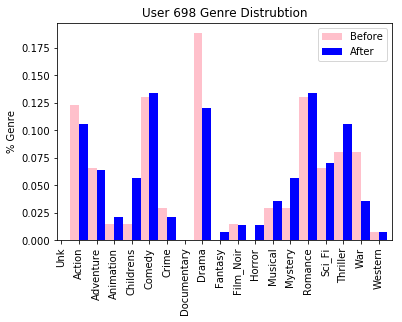

In [87]:
print("users in test set: ", lowest_cosim_ids)
user = lowest_cosim_ids[1]
movies_rec = user_history[user]['item_ids']
movie_set1 = movies_rec[0:60]
movie_set2 = movies_rec[61:121]

genre_matrix1 = movie_genres(movie_set1)
genre_matrix2 = movie_genres(movie_set2)
dist1 = genre_distribution(genre_matrix1)
dist2 = genre_distribution(genre_matrix2)
similarity = cosine_similarity(np.array(dist1).reshape(1,-1), np.array(dist2).reshape(1,-1))[0][0]

print("\nPrevious 60 Movie Genre Distribution \n", dist1)
print()
print("\nNext 60 Movie Genre Distribution \n", dist2)
print()
print("\n% Chnge per Genre \n", dist1-dist2)
print(similarity)

plot_histogram(user, dist1, dist2)

In [70]:
plt.bar([dist1, dist2], label=['dist1', 'dist2'])
plt.legend(loc='upper right')
plt.show()

TypeError: bar() missing 1 required positional argument: 'height'

In [107]:
def moving_average(x):
    avgs = []
    for i, v in enumerate(x):
        avgs.append(np.sum(x[:i]) / i)
    return avgs

In [ ]:
mses = moving_average(test_ses)
print(mses[-1])

/Users/colbywise/anaconda2/envs/adv_ml/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


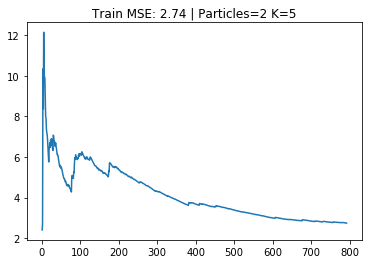

In [114]:
mses = moving_average(ses)
plt.plot(range(len(mses)), mses)
plt.title("Train MSE: {:.2f} | Particles=2 K=5".format(mses[-1]))
plt.savefig("MSE_graph.png")
plt.show()

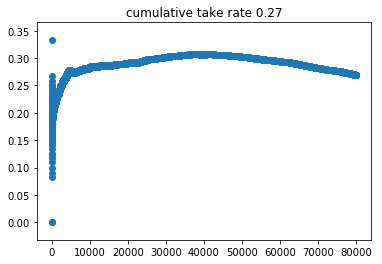

In [56]:
plt.scatter(range(len(ctr_hist)), ctr_hist)
plt.title("cumulative take rate {:.2f}".format(ctr_hist[-1]))
plt.show()